In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
def html_table(df):
    count = len(df.columns.to_list())
    ph = count
    
    print('<table>')
    print('\t<tr>')
    for col in df.columns:
        print(f'\t\t<th>{col}</th>')
    print('\t</tr>')
    for index, row in df.iterrows():
        for i in range(len(row)):
            if count % ph == 0:
                print('\t<tr>')

            print(f'\t\t<td>{row[i]}</td>') 
            count += 1 

            if count % ph == 0:
                print('\t</tr>')
    print('</table>')

In [3]:
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'

In [4]:
df = pd.read_csv(url)
df = df[df["location"] == "Australia"]
df = df[["date", "total_cases"]]
df["date"] = pd.to_datetime(df["date"])
df = df.reset_index().drop("index", axis=1)

In [5]:
df.head()

,date,total_cases
0,2020-01-26,4.0
1,2020-01-27,5.0
2,2020-01-28,5.0
3,2020-01-29,6.0
4,2020-01-30,9.0


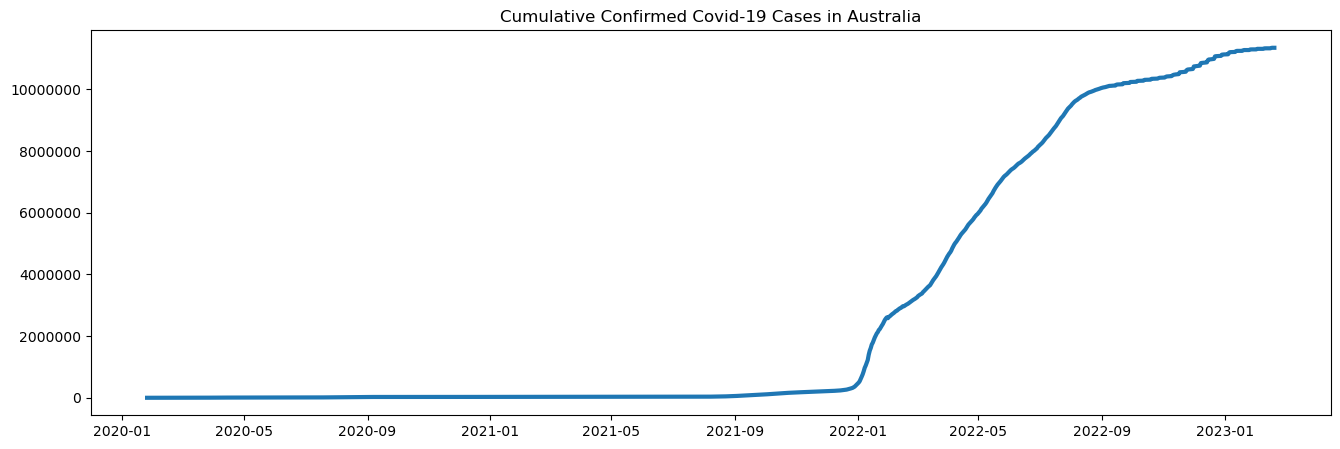

In [6]:
plt.figure(figsize=(16,5))
plt.plot(df["date"], df["total_cases"], linewidth=3)
plt.ticklabel_format(axis="y", style='plain')
plt.title("Cumulative Confirmed Covid-19 Cases in Australia")
plt.savefig('covid_arima_image_1.png', dpi = 400, facecolor="#F5F3F4", bbox_inches='tight')

In order to optimise the ARIMA model, we need to make the time series stationary as it's easier to model and make predictions. 

Splitting the data and setting the test data to the last 30 days

In [7]:
msk = (df.index < len(df)-30)
df_train = df[msk].copy()
df_test = df[~msk].copy()

In [8]:
adf_test = adfuller(df_train["total_cases"])
print(f"{adf_test[1]:.3f}")

0.976


We can check stationarity using an Augmented Dickey-Fuller (ADF) test.
We are check if the p-value is greater than, less than or equal to 0.05.
If p-value > 0.05: the ADF failed to reject the null hypothesis and the data is non-stationary.
If p-value <= 0.05: the ADF rejected the null hypothesis and the data is stationary.

Determining the d for I(d). To determine d we need check seasonality, stationarity and differencing using ACF and PACF plots.

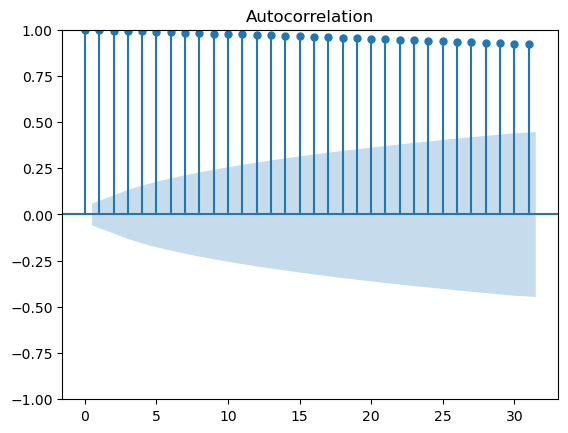

In [9]:
acf_original = plot_acf(df_train["total_cases"])
plt.savefig('covid_arima_image_2.png', dpi = 400, facecolor="#F5F3F4", bbox_inches='tight')

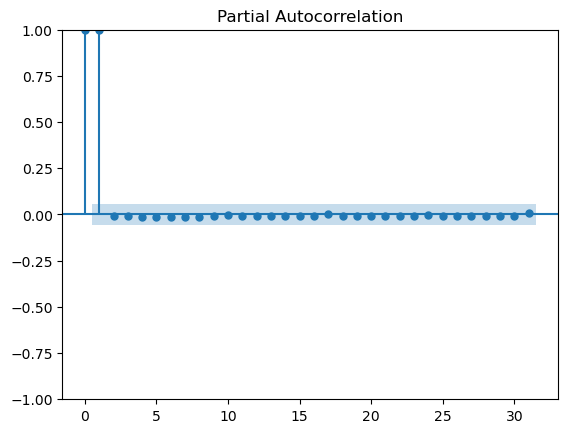

In [10]:
pacf_original = plot_pacf(df_train["total_cases"])
plt.savefig('covid_arima_image_3.png', dpi = 400, facecolor="#F5F3F4", bbox_inches='tight')

The ACF plot is showing exponential decay, this is indicative of a tread. We can remove this trend by applying differencing to our data.

While the PACF is showing strong positive correlation at lag 1 and also cuts off after lag 1.

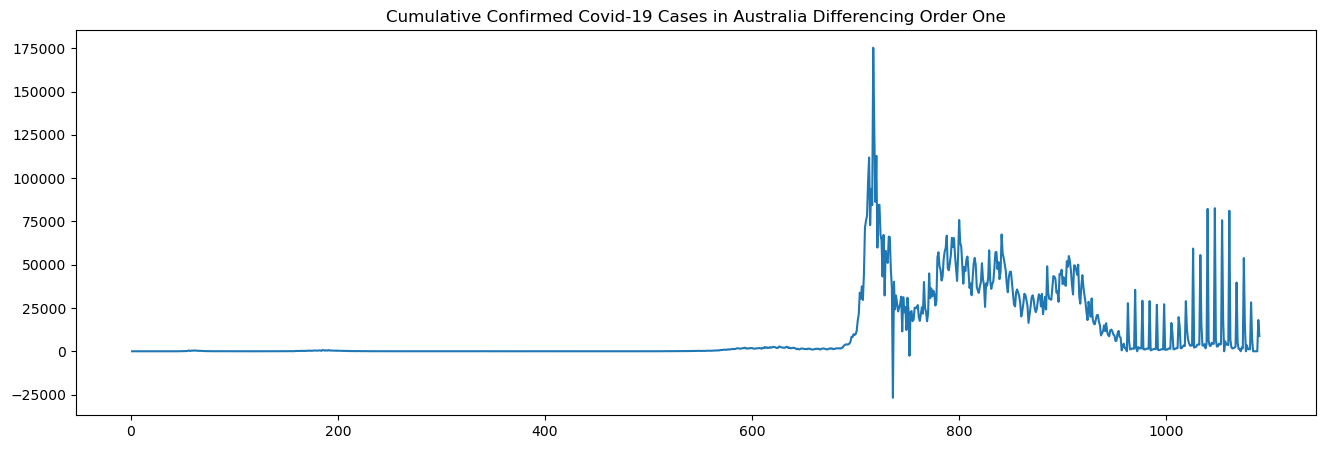

In [11]:
df_train_diff = df_train["total_cases"].diff().dropna()
df_train_diff.plot(figsize=(16,5))
plt.title("Cumulative Confirmed Covid-19 Cases in Australia Differencing Order One")
plt.savefig('covid_arima_image_4.png', dpi = 400, facecolor="#F5F3F4", bbox_inches='tight')

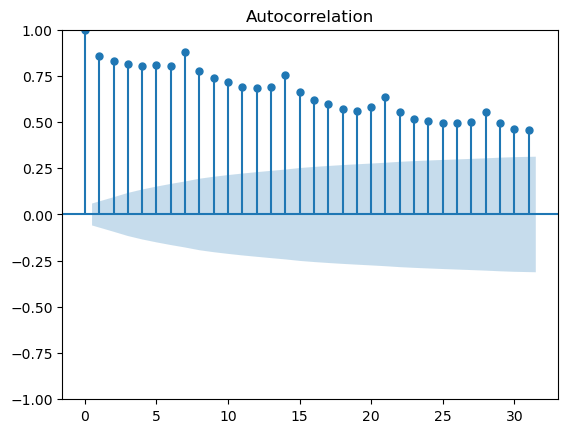

In [12]:
acf_diff = plot_acf(df_train_diff)
plt.savefig('covid_arima_image_5.png', dpi = 400, facecolor="#F5F3F4", bbox_inches='tight')

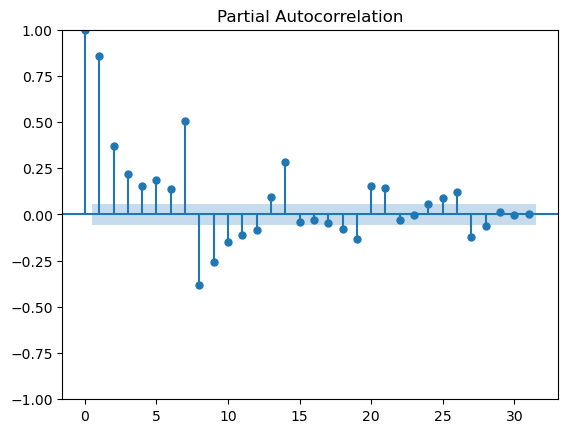

In [13]:
pacf_diff = plot_pacf(df_train_diff)
plt.savefig('covid_arima_image_6.png', dpi = 400, facecolor="#F5F3F4", bbox_inches='tight')

The ACF plot is still displaying decay, there is still a trend. We can applying differencing at order 2 to resolve this.

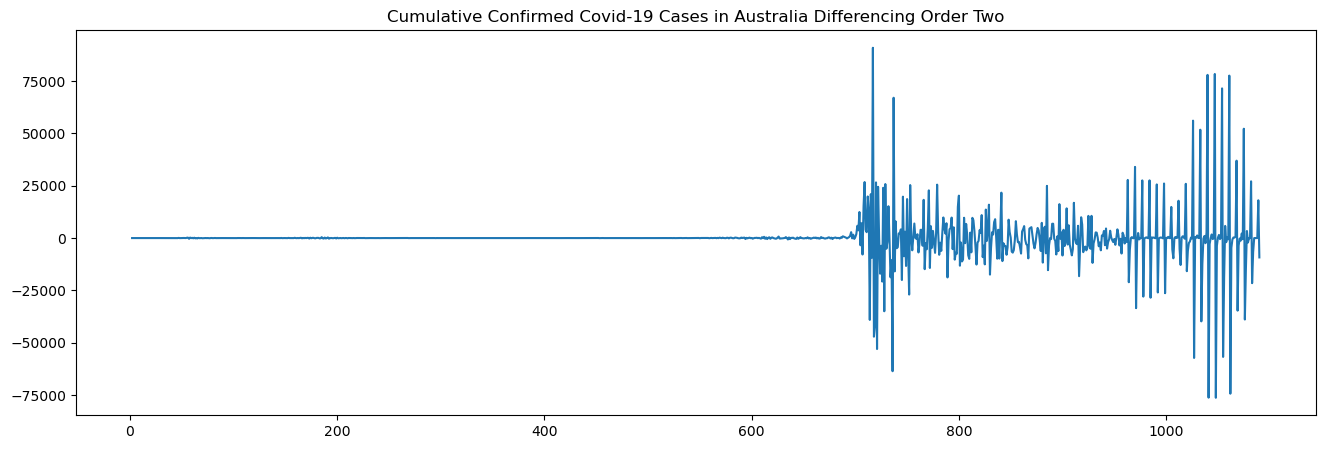

In [14]:
df_train_diff_o2 = df_train_diff.diff()
df_train_diff_o2.plot(figsize=(16,5))
plt.title("Cumulative Confirmed Covid-19 Cases in Australia Differencing Order Two")
plt.savefig('covid_arima_image_7.png', dpi = 400, facecolor="#F5F3F4", bbox_inches='tight')

In [15]:
df_train_diff_o2 = df_train_diff_o2.dropna()

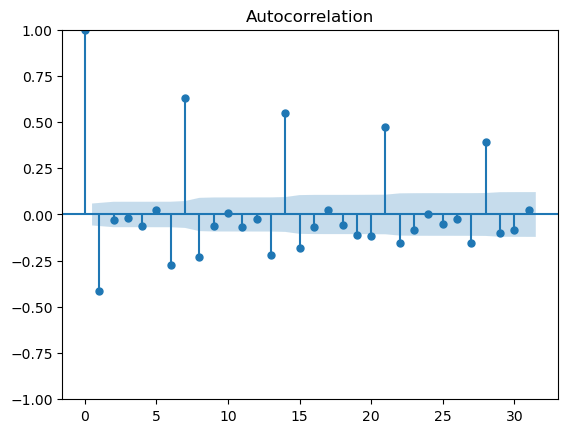

In [16]:
acf_diff_o2 = plot_acf(df_train_diff_o2)
plt.savefig('covid_arima_image_8.png', dpi = 400, facecolor="#F5F3F4", bbox_inches='tight')

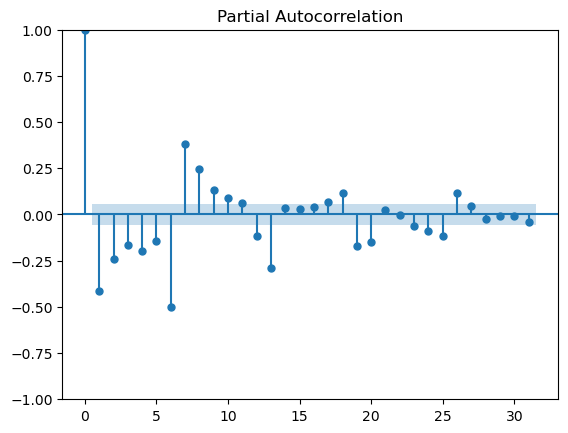

In [17]:
pacf_diff_o2 = plot_pacf(df_train_diff_o2)
plt.savefig('covid_arima_image_9.png', dpi = 400, facecolor="#F5F3F4", bbox_inches='tight')

At difference order 2 we can see that the data is now stationary and the ACF isn't showing a decaying trend.

Therefore we will use d = 2

In [18]:
model_order = []
AIC = []
i = 2
for ar in range(6):
    for ma in range(6):
        model = ARIMA(df_train["total_cases"], order=(ar, i, ma))
        model_fit = model.fit()
        model_order.append(f"ARIMA({ar},{i},{ma})")
        AIC.append(model_fit.aic)

In [19]:
arima_order_df = pd.DataFrame(list(zip(model_order, AIC)), columns=["ARIMA(p,d,q)", "AIC"])
arima_order_df.sort_values("AIC").head(5)

,"ARIMA(p,d,q)",AIC
35,"ARIMA(5,2,5)",22604.293600
29,"ARIMA(4,2,5)",22613.788653
34,"ARIMA(5,2,4)",22634.093117
33,"ARIMA(5,2,3)",22670.079727
28,"ARIMA(4,2,4)",22675.121442


In [20]:
html_table(arima_order_df.sort_values("AIC").head(5))

<table>
	<tr>
		<th>ARIMA(p,d,q)</th>
		<th>AIC</th>
	</tr>
	<tr>
		<td>ARIMA(5,2,5)</td>
		<td>22604.293600023615</td>
	</tr>
	<tr>
		<td>ARIMA(4,2,5)</td>
		<td>22613.788653003412</td>
	</tr>
	<tr>
		<td>ARIMA(5,2,4)</td>
		<td>22634.093116745775</td>
	</tr>
	<tr>
		<td>ARIMA(5,2,3)</td>
		<td>22670.079727235585</td>
	</tr>
	<tr>
		<td>ARIMA(4,2,4)</td>
		<td>22675.12144181684</td>
	</tr>
</table>


In [21]:
model = ARIMA(df_train["total_cases"], order=(5,2,5))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            total_cases   No. Observations:                 1091
Model:                 ARIMA(5, 2, 5)   Log Likelihood              -11291.147
Date:                Tue, 21 Feb 2023   AIC                          22604.294
Time:                        13:12:31   BIC                          22659.217
Sample:                             0   HQIC                         22625.082
                               - 1091                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4479      0.075     -5.980      0.000      -0.595      -0.301
ar.L2          0.4066      0.042      9.670      0.000       0.324       0.489
ar.L3         -0.4038      0.025    -16.166      0.0

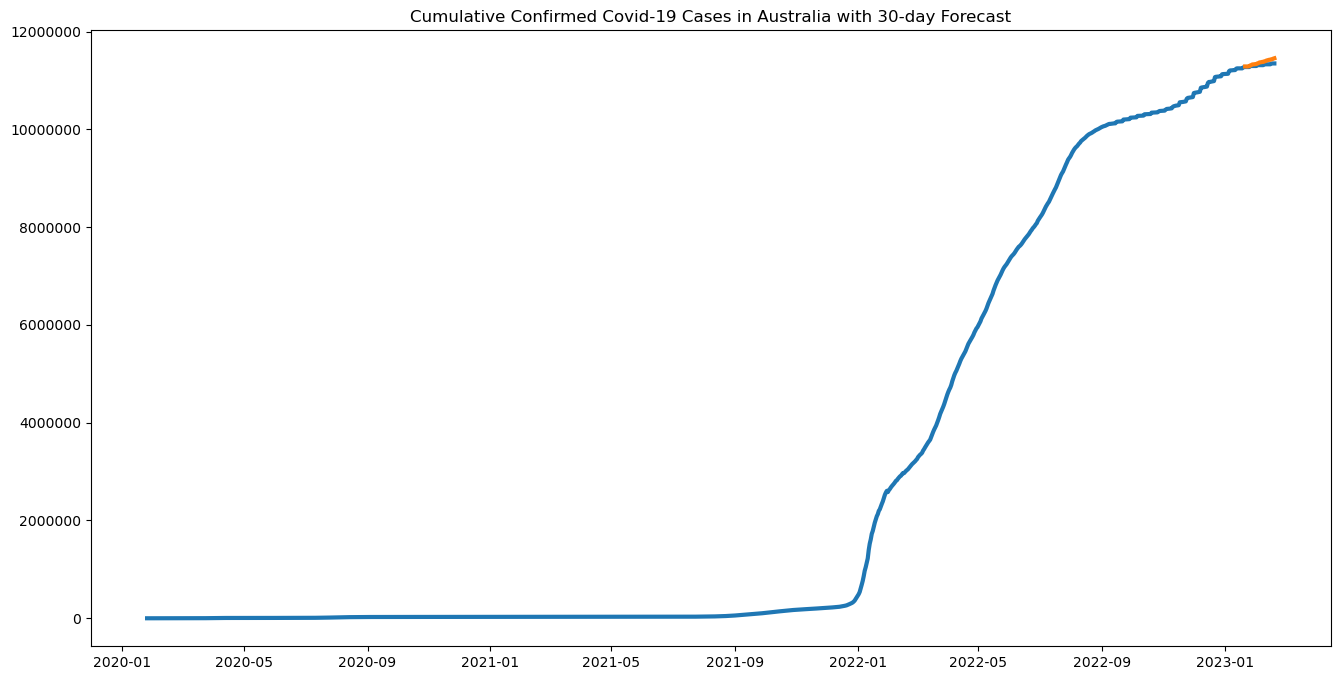

In [22]:
forecast = model_fit.forecast(len(df_test))
df["date"] = pd.to_datetime(df["date"])
df["ARIMA"] = [None]*len(df_train["total_cases"]) + list(forecast)

plt.figure(figsize=(16,8))
plt.plot(df["date"], df["total_cases"], linewidth=3)
plt.plot(df["date"], df["ARIMA"], linewidth=3)
plt.ticklabel_format(axis="y", style='plain')
plt.title("Cumulative Confirmed Covid-19 Cases in Australia with 30-day Forecast")

plt.savefig('covid_arima_image_10.png', dpi = 400, facecolor="#F5F3F4", bbox_inches='tight')

In [23]:
mae = mean_absolute_error(df_test["total_cases"], forecast)
mape = mean_absolute_percentage_error(df_test["total_cases"], forecast)
rmse = np.sqrt(mean_absolute_error(df_test["total_cases"], forecast))

print(f"mae: {mae}")
print(f"mape: {mape}")
print(f"rmse: {rmse}")

mae: 53002.22428526214
mape: 0.004680871555177652
rmse: 230.2221194526324
